In [1]:
import uuid
import os
import asyncio
from pprint import pp
from dotenv import load_dotenv
from tempfile import mkdtemp

from jobs import Worker
from shared import MongoDbConnector, save_uploaded_file, upload_blob

load_dotenv('../assets/.env_dev')

MONGO_URI = os.getenv('MONGO_URI')
GOOGLE_APPLICATION_CREDENTIALS = os.getenv('GOOGLE_APPLICATION_CREDENTIALS')
BUCKET_NAME = os.getenv('BUCKET_NAME')
DB_NAME = os.getenv('DB_NAME')

db_connector = MongoDbConnector(connection_uri=MONGO_URI, database_id=DB_NAME, connector_id="test_worker")

In [2]:
omex_dir = "../model-examples/sbml-core/Elowitz-Nature-2000-Repressilator"
uploaded_file = omex_dir + '.omex'
ground_truth_report = None  # os.path.join(omex_dir, 'reports.h5')

os.path.exists(uploaded_file)

True

In [3]:
job_id = str(uuid.uuid4())
_time = db_connector.timestamp()

In [5]:
pending_jobs = db_connector.pending_jobs()
if len(pending_jobs) > 0:
    print(f'There are {len(pending_jobs)} pending jobs that will be deleted.')
    for doc in pending_jobs:
        db_connector.db.pending_jobs.delete_one(doc)

There are 4 pending jobs that will be deleted.


In [4]:
db_connector.pending_jobs()

[{'_id': ObjectId('66a572d06bbfeecd576539de'),
  'status': 'PENDING',
  'job_id': 'b863a655-5d8c-4de3-a6cd-750b0cb947a2',
  'omex_path': 'uploads/b863a655-5d8c-4de3-a6cd-750b0cb947a2/Elowitz-Nature-2000-Repressilator.omex',
  'simulators': ['amici', 'copasi', 'tellurium'],
  'comparison_id': 'test0',
  'timestamp': '2024-07-27 22:21:03.274290',
  'ground_truth_report_path': None,
  'include_outputs': True}]

In [6]:
# save_dest = mkdtemp()
# bucket params
upload_prefix = f"uploads/{job_id}/"
bucket_prefix = f"gs://{BUCKET_NAME}/" + upload_prefix

# Save uploaded omex file to Google Cloud Storage
# omex_fp = await save_uploaded_file(uploaded_file, save_dest)
# for local dev, the file is already written, duh!
uploaded_file_name = uploaded_file.split('/')[-1]
omex_fp = uploaded_file
omex_blob_dest = upload_prefix + uploaded_file_name
omex_path = omex_blob_dest  # bucket_prefix + uploaded_file

upload_blob(bucket_name=BUCKET_NAME, source_file_name=omex_fp, destination_blob_name=omex_blob_dest)

../model-examples/sbml-core/Elowitz-Nature-2000-Repressilator.omex


{'message': 'File ../model-examples/sbml-core/Elowitz-Nature-2000-Repressilator.omex uploaded to uploads/5064a6b3-59a9-4778-8e59-c4e58b1bc2a2/Elowitz-Nature-2000-Repressilator.omex.'}

In [7]:
# Save uploaded reports file to Google Cloud Storage if applicable
report_fp = None
report_blob_dest = None
if ground_truth_report:
    # report_fp = await save_uploaded_file(ground_truth_report, save_dest)
    report_blob_dest = upload_prefix + ground_truth_report
    upload_blob(BUCKET_NAME, report_fp, report_blob_dest)
report_path = report_blob_dest if report_fp else None # bucket_prefix + ground_truth_report.filename if report_fp 

In [8]:
# run insert job
simulators = ['amici', 'copasi', 'tellurium']
comparison_id = f"test_{job_id}"

In [9]:
pending_job_doc = await db_connector.insert_job_async(
        collection_name="pending_jobs",
        status="PENDING",
        job_id=job_id,
        omex_path=omex_path,
        simulators=simulators,
        comparison_id=comparison_id or f"uniform-time-course-comparison-{job_id}",
        timestamp=_time,
        ground_truth_report_path=report_path,
        include_outputs=True
)

In [5]:
jobs = db_connector.pending_jobs().copy()

jobs

[{'_id': ObjectId('66a572d06bbfeecd576539de'),
  'status': 'PENDING',
  'job_id': 'b863a655-5d8c-4de3-a6cd-750b0cb947a2',
  'omex_path': 'uploads/b863a655-5d8c-4de3-a6cd-750b0cb947a2/Elowitz-Nature-2000-Repressilator.omex',
  'simulators': ['amici', 'copasi', 'tellurium'],
  'comparison_id': 'test0',
  'timestamp': '2024-07-27 22:21:03.274290',
  'ground_truth_report_path': None,
  'include_outputs': True}]

In [6]:
job = jobs.pop()

job

{'_id': ObjectId('66a572d06bbfeecd576539de'),
 'status': 'PENDING',
 'job_id': 'b863a655-5d8c-4de3-a6cd-750b0cb947a2',
 'omex_path': 'uploads/b863a655-5d8c-4de3-a6cd-750b0cb947a2/Elowitz-Nature-2000-Repressilator.omex',
 'simulators': ['amici', 'copasi', 'tellurium'],
 'comparison_id': 'test0',
 'timestamp': '2024-07-27 22:21:03.274290',
 'ground_truth_report_path': None,
 'include_outputs': True}

In [7]:
from jobs import BUCKET_NAME

BUCKET_NAME

'bio-check-requests-1'

In [ ]:
from jobs import Supervisor

supervisor = Supervisor(db_connector=db_connector)

Archive contains 1 SED-ML documents with 1 models, 1 simulations, 1 tasks, 1 reports, and 1 plots:
  simulation.sedml:
    Tasks (1):
      task
    Reports (1):
      report: 7 data sets
    Plots (1):
      Figure_1c: 3 curves

Executing SED-ML file 1: simulation.sedml ...
  Found 1 tasks and 2 outputs:
    Tasks:
      `task`
    Outputs:
      `Figure_1c`
      `report`
  Executing task 1: `task`
    Executing simulation ...

/Users/alexanderpatrie/Library/Caches/pypoetry/virtualenvs/bio-check-lb7k8x6F-py3.9/lib/python3.9/site-packages/biosimulators_utils/warnings.py:31: StandardOutputNotLoggedWarning: Standard output and error could not be logged because capturer is not installed. To install capturer, install BioSimulators utils with the `logging` option (`pip install biosimulators-utils[logging]`).
  warnings.warn(termcolor.colored(message, Colors.warning.value), category)
/Users/alexanderpatrie/Library/Caches/pypoetry/virtualenvs/bio-check-lb7k8x6F-py3.9/lib/python3.9/site-packages/biosimulators_utils/warnings.py:31: BioSimulatorsWarning: The SED document is potentially incorrect.
  - This tool validates XPaths for model changes and variables against their unmodified target models. As a result, this tool does not fully validate these XPaths. These XPaths could be invalidated by changes to their target models.
  - Model `model` has warnings.
    - The model file `BIOMD0000000012_url.xml` has warnings.
   

 succeeded
    Generating 2 outputs ...
      Generating output 1: `report` ... succeeded
      Generating output 2: `Figure_1c` ...

/Users/alexanderpatrie/Library/Caches/pypoetry/virtualenvs/bio-check-lb7k8x6F-py3.9/lib/python3.9/site-packages/biosimulators_utils/warnings.py:31: IllogicalVizWarning: A title could not be inferred for the Y axis because the Y data generators have inconsistent names.
  warnings.warn(termcolor.colored(message, Colors.warning.value), category)


 succeeded

Bundling outputs ...
Cleaning up ...
Archive contains 1 SED-ML documents with 1 models, 1 simulations, 1 tasks, 1 reports, and 1 plots:
  simulation.sedml:
    Tasks (1):
      task
    Reports (1):
      report: 7 data sets
    Plots (1):
      Figure_1c: 3 curves

Executing SED-ML file 1: simulation.sedml ...
  Found 1 tasks and 2 outputs:
    Tasks:
      `task`
    Outputs:
      `Figure_1c`
      `report`
  Executing task 1: `task`
    Executing simulation ...

/Users/alexanderpatrie/Library/Caches/pypoetry/virtualenvs/bio-check-lb7k8x6F-py3.9/lib/python3.9/site-packages/biosimulators_utils/warnings.py:31: StandardOutputNotLoggedWarning: Standard output and error could not be logged because capturer is not installed. To install capturer, install BioSimulators utils with the `logging` option (`pip install biosimulators-utils[logging]`).
  warnings.warn(termcolor.colored(message, Colors.warning.value), category)
/Users/alexanderpatrie/Library/Caches/pypoetry/virtualenvs/bio-check-lb7k8x6F-py3.9/lib/python3.9/site-packages/biosimulators_utils/warnings.py:31: BioSimulatorsWarning: The SED document is potentially incorrect.
  - This tool validates XPaths for model changes and variables against their unmodified target models. As a result, this tool does not fully validate these XPaths. These XPaths could be invalidated by changes to their target models.
  - Model `model` has warnings.
    - The model file `BIOMD0000000012_url.xml` has warnings.
   

 succeeded
    Generating 2 outputs ...
      Generating output 1: `report` ... succeeded
      Generating output 2: `Figure_1c` ... succeeded

Bundling outputs ...
Cleaning up ...


/Users/alexanderpatrie/Library/Caches/pypoetry/virtualenvs/bio-check-lb7k8x6F-py3.9/lib/python3.9/site-packages/biosimulators_utils/warnings.py:31: IllogicalVizWarning: A title could not be inferred for the Y axis because the Y data generators have inconsistent names.
  warnings.warn(termcolor.colored(message, Colors.warning.value), category)


Archive contains 1 SED-ML documents with 1 models, 1 simulations, 1 tasks, 1 reports, and 1 plots:
  simulation.sedml:
    Tasks (1):
      task
    Reports (1):
      report: 7 data sets
    Plots (1):
      Figure_1c: 3 curves

Executing SED-ML file 1: simulation.sedml ...
  Found 1 tasks and 2 outputs:
    Tasks:
      `task`
    Outputs:
      `Figure_1c`
      `report`
  Executing task 1: `task`
    Executing simulation ... succeeded
    Generating 2 outputs ...
      Generating output 1: `report` ... succeeded
      Generating output 2: `Figure_1c` ... succeeded

Bundling outputs ...
Cleaning up ...
Archive contains 1 SED-ML documents with 1 models, 1 simulations, 1 tasks, 1 reports, and 1 plots:
  simulation.sedml:
    Tasks (1):
      task
    Reports (1):
      report: 7 data sets
    Plots (1):
      Figure_1c: 3 curves

Executing SED-ML file 1: simulation.sedml ...
  Found 1 tasks and 2 outputs:
    Tasks:
      `task`
    Outputs:
      `Figure_1c`
      `report`
  Executin

/Users/alexanderpatrie/Library/Caches/pypoetry/virtualenvs/bio-check-lb7k8x6F-py3.9/lib/python3.9/site-packages/biosimulators_utils/warnings.py:31: StandardOutputNotLoggedWarning:

Standard output and error could not be logged because capturer is not installed. To install capturer, install BioSimulators utils with the `logging` option (`pip install biosimulators-utils[logging]`).

/Users/alexanderpatrie/Library/Caches/pypoetry/virtualenvs/bio-check-lb7k8x6F-py3.9/lib/python3.9/site-packages/biosimulators_utils/warnings.py:31: BioSimulatorsWarning:

The SED document is potentially incorrect.
  - This tool validates XPaths for model changes and variables against their unmodified target models. As a result, this tool does not fully validate these XPaths. These XPaths could be invalidated by changes to their target models.
  - Model `model` has warnings.
    - The model file `BIOMD0000000012_url.xml` has warnings.
      - 21 warnings of type SBML unit consistency (99505). The following is 

 succeeded
    Generating 2 outputs ...
      Generating output 1: `report` ... succeeded
      Generating output 2: `Figure_1c` ... succeeded

Bundling outputs ...
Cleaning up ...
Archive contains 1 SED-ML documents with 1 models, 1 simulations, 1 tasks, 1 reports, and 1 plots:
  simulation.sedml:
    Tasks (1):
      task
    Reports (1):
      report: 7 data sets
    Plots (1):
      Figure_1c: 3 curves

Executing SED-ML file 1: simulation.sedml ...
  Found 1 tasks and 2 outputs:
    Tasks:
      `task`
    Outputs:
      `Figure_1c`
      `report`
  Executing task 1: `task`
    Executing simulation ...

/Users/alexanderpatrie/Library/Caches/pypoetry/virtualenvs/bio-check-lb7k8x6F-py3.9/lib/python3.9/site-packages/biosimulators_utils/warnings.py:31: IllogicalVizWarning:

A title could not be inferred for the Y axis because the Y data generators have inconsistent names.

/Users/alexanderpatrie/Library/Caches/pypoetry/virtualenvs/bio-check-lb7k8x6F-py3.9/lib/python3.9/site-packages/biosimulators_utils/warnings.py:31: StandardOutputNotLoggedWarning:

Standard output and error could not be logged because capturer is not installed. To install capturer, install BioSimulators utils with the `logging` option (`pip install biosimulators-utils[logging]`).

/Users/alexanderpatrie/Library/Caches/pypoetry/virtualenvs/bio-check-lb7k8x6F-py3.9/lib/python3.9/site-packages/biosimulators_utils/warnings.py:31: BioSimulatorsWarning:

The SED document is potentially incorrect.
  - This tool validates XPaths for model changes and variables against their unmodified target models. As a result, this tool does 

 succeeded
    Generating 2 outputs ...
      Generating output 1: `report` ... succeeded
      Generating output 2: `Figure_1c` ... succeeded

Bundling outputs ...
Cleaning up ...
Archive contains 1 SED-ML documents with 1 models, 1 simulations, 1 tasks, 1 reports, and 1 plots:
  simulation.sedml:
    Tasks (1):
      task
    Reports (1):
      report: 7 data sets
    Plots (1):
      Figure_1c: 3 curves

Executing SED-ML file 1: simulation.sedml ...
  Found 1 tasks and 2 outputs:
    Tasks:
      `task`
    Outputs:
      `Figure_1c`
      `report`
  Executing task 1: `task`
    Executing simulation ... succeeded
    Generating 2 outputs ...
      Generating output 1: `report` ... succeeded
      Generating output 2: `Figure_1c` ... succeeded

Bundling outputs ...
Cleaning up ...
Archive contains 1 SED-ML documents with 1 models, 1 simulations, 1 tasks, 1 reports, and 1 plots:
  simulation.sedml:
    Tasks (1):
      task
    Reports (1):
      report: 7 data sets
    Plots (1):
   

/Users/alexanderpatrie/Library/Caches/pypoetry/virtualenvs/bio-check-lb7k8x6F-py3.9/lib/python3.9/site-packages/biosimulators_utils/warnings.py:31: IllogicalVizWarning:

A title could not be inferred for the Y axis because the Y data generators have inconsistent names.

/Users/alexanderpatrie/Library/Caches/pypoetry/virtualenvs/bio-check-lb7k8x6F-py3.9/lib/python3.9/site-packages/biosimulators_utils/warnings.py:31: StandardOutputNotLoggedWarning:

Standard output and error could not be logged because capturer is not installed. To install capturer, install BioSimulators utils with the `logging` option (`pip install biosimulators-utils[logging]`).

/Users/alexanderpatrie/Library/Caches/pypoetry/virtualenvs/bio-check-lb7k8x6F-py3.9/lib/python3.9/site-packages/biosimulators_utils/warnings.py:31: BioSimulatorsWarning:

The SED document is potentially incorrect.
  - This tool validates XPaths for model changes and variables against their unmodified target models. As a result, this tool does 

 succeeded
    Generating 2 outputs ...
      Generating output 1: `report` ... succeeded
      Generating output 2: `Figure_1c` ... succeeded

Bundling outputs ...
Cleaning up ...
Archive contains 1 SED-ML documents with 1 models, 1 simulations, 1 tasks, 1 reports, and 1 plots:
  simulation.sedml:
    Tasks (1):
      task
    Reports (1):
      report: 7 data sets
    Plots (1):
      Figure_1c: 3 curves

Executing SED-ML file 1: simulation.sedml ...
  Found 1 tasks and 2 outputs:
    Tasks:
      `task`
    Outputs:
      `Figure_1c`
      `report`
  Executing task 1: `task`
    Executing simulation ...

/Users/alexanderpatrie/Library/Caches/pypoetry/virtualenvs/bio-check-lb7k8x6F-py3.9/lib/python3.9/site-packages/biosimulators_utils/warnings.py:31: IllogicalVizWarning:

A title could not be inferred for the Y axis because the Y data generators have inconsistent names.

/Users/alexanderpatrie/Library/Caches/pypoetry/virtualenvs/bio-check-lb7k8x6F-py3.9/lib/python3.9/site-packages/biosimulators_utils/warnings.py:31: StandardOutputNotLoggedWarning:

Standard output and error could not be logged because capturer is not installed. To install capturer, install BioSimulators utils with the `logging` option (`pip install biosimulators-utils[logging]`).

/Users/alexanderpatrie/Library/Caches/pypoetry/virtualenvs/bio-check-lb7k8x6F-py3.9/lib/python3.9/site-packages/biosimulators_utils/warnings.py:31: BioSimulatorsWarning:

The SED document is potentially incorrect.
  - This tool validates XPaths for model changes and variables against their unmodified target models. As a result, this tool does 

 succeeded
    Generating 2 outputs ...
      Generating output 1: `report` ... succeeded
      Generating output 2: `Figure_1c` ... succeeded

Bundling outputs ...
Cleaning up ...
Archive contains 1 SED-ML documents with 1 models, 1 simulations, 1 tasks, 1 reports, and 1 plots:
  simulation.sedml:
    Tasks (1):
      task
    Reports (1):
      report: 7 data sets
    Plots (1):
      Figure_1c: 3 curves

Executing SED-ML file 1: simulation.sedml ...
  Found 1 tasks and 2 outputs:
    Tasks:
      `task`
    Outputs:
      `Figure_1c`
      `report`
  Executing task 1: `task`
    Executing simulation ... succeeded
    Generating 2 outputs ...
      Generating output 1: `report` ... succeeded
      Generating output 2: `Figure_1c` ... succeeded

Bundling outputs ...
Cleaning up ...
Archive contains 1 SED-ML documents with 1 models, 1 simulations, 1 tasks, 1 reports, and 1 plots:
  simulation.sedml:
    Tasks (1):
      task
    Reports (1):
      report: 7 data sets
    Plots (1):
   

/Users/alexanderpatrie/Library/Caches/pypoetry/virtualenvs/bio-check-lb7k8x6F-py3.9/lib/python3.9/site-packages/biosimulators_utils/warnings.py:31: IllogicalVizWarning:

A title could not be inferred for the Y axis because the Y data generators have inconsistent names.

/Users/alexanderpatrie/Library/Caches/pypoetry/virtualenvs/bio-check-lb7k8x6F-py3.9/lib/python3.9/site-packages/biosimulators_utils/warnings.py:31: StandardOutputNotLoggedWarning:

Standard output and error could not be logged because capturer is not installed. To install capturer, install BioSimulators utils with the `logging` option (`pip install biosimulators-utils[logging]`).

/Users/alexanderpatrie/Library/Caches/pypoetry/virtualenvs/bio-check-lb7k8x6F-py3.9/lib/python3.9/site-packages/biosimulators_utils/warnings.py:31: BioSimulatorsWarning:

The SED document is potentially incorrect.
  - This tool validates XPaths for model changes and variables against their unmodified target models. As a result, this tool does 

 succeeded
    Generating 2 outputs ...
      Generating output 1: `report` ... succeeded
      Generating output 2: `Figure_1c` ... succeeded

Bundling outputs ...
Cleaning up ...
Archive contains 1 SED-ML documents with 1 models, 1 simulations, 1 tasks, 1 reports, and 1 plots:
  simulation.sedml:
    Tasks (1):
      task
    Reports (1):
      report: 7 data sets
    Plots (1):
      Figure_1c: 3 curves

Executing SED-ML file 1: simulation.sedml ...
  Found 1 tasks and 2 outputs:
    Tasks:
      `task`
    Outputs:
      `Figure_1c`
      `report`
  Executing task 1: `task`
    Executing simulation ...

/Users/alexanderpatrie/Library/Caches/pypoetry/virtualenvs/bio-check-lb7k8x6F-py3.9/lib/python3.9/site-packages/biosimulators_utils/warnings.py:31: IllogicalVizWarning:

A title could not be inferred for the Y axis because the Y data generators have inconsistent names.

/Users/alexanderpatrie/Library/Caches/pypoetry/virtualenvs/bio-check-lb7k8x6F-py3.9/lib/python3.9/site-packages/biosimulators_utils/warnings.py:31: StandardOutputNotLoggedWarning:

Standard output and error could not be logged because capturer is not installed. To install capturer, install BioSimulators utils with the `logging` option (`pip install biosimulators-utils[logging]`).

/Users/alexanderpatrie/Library/Caches/pypoetry/virtualenvs/bio-check-lb7k8x6F-py3.9/lib/python3.9/site-packages/biosimulators_utils/warnings.py:31: BioSimulatorsWarning:

The SED document is potentially incorrect.
  - This tool validates XPaths for model changes and variables against their unmodified target models. As a result, this tool does 

 succeeded
    Generating 2 outputs ...
      Generating output 1: `report` ... succeeded
      Generating output 2: `Figure_1c` ... succeeded

Bundling outputs ...
Cleaning up ...
Archive contains 1 SED-ML documents with 1 models, 1 simulations, 1 tasks, 1 reports, and 1 plots:
  simulation.sedml:
    Tasks (1):
      task
    Reports (1):
      report: 7 data sets
    Plots (1):
      Figure_1c: 3 curves

Executing SED-ML file 1: simulation.sedml ...
  Found 1 tasks and 2 outputs:
    Tasks:
      `task`
    Outputs:
      `Figure_1c`
      `report`
  Executing task 1: `task`
    Executing simulation ... succeeded
    Generating 2 outputs ...
      Generating output 1: `report` ... succeeded
      Generating output 2: `Figure_1c` ... succeeded

Bundling outputs ...
Cleaning up ...
Archive contains 1 SED-ML documents with 1 models, 1 simulations, 1 tasks, 1 reports, and 1 plots:
  simulation.sedml:
    Tasks (1):
      task
    Reports (1):
      report: 7 data sets
    Plots (1):
   

/Users/alexanderpatrie/Library/Caches/pypoetry/virtualenvs/bio-check-lb7k8x6F-py3.9/lib/python3.9/site-packages/biosimulators_utils/warnings.py:31: IllogicalVizWarning:

A title could not be inferred for the Y axis because the Y data generators have inconsistent names.

/Users/alexanderpatrie/Library/Caches/pypoetry/virtualenvs/bio-check-lb7k8x6F-py3.9/lib/python3.9/site-packages/biosimulators_utils/warnings.py:31: StandardOutputNotLoggedWarning:

Standard output and error could not be logged because capturer is not installed. To install capturer, install BioSimulators utils with the `logging` option (`pip install biosimulators-utils[logging]`).

/Users/alexanderpatrie/Library/Caches/pypoetry/virtualenvs/bio-check-lb7k8x6F-py3.9/lib/python3.9/site-packages/biosimulators_utils/warnings.py:31: BioSimulatorsWarning:

The SED document is potentially incorrect.
  - This tool validates XPaths for model changes and variables against their unmodified target models. As a result, this tool does 

 succeeded
    Generating 2 outputs ...
      Generating output 1: `report` ... succeeded
      Generating output 2: `Figure_1c` ... succeeded

Bundling outputs ...
Cleaning up ...
Archive contains 1 SED-ML documents with 1 models, 1 simulations, 1 tasks, 1 reports, and 1 plots:
  simulation.sedml:
    Tasks (1):
      task
    Reports (1):
      report: 7 data sets
    Plots (1):
      Figure_1c: 3 curves

Executing SED-ML file 1: simulation.sedml ...
  Found 1 tasks and 2 outputs:
    Tasks:
      `task`
    Outputs:
      `Figure_1c`
      `report`
  Executing task 1: `task`
    Executing simulation ...

/Users/alexanderpatrie/Library/Caches/pypoetry/virtualenvs/bio-check-lb7k8x6F-py3.9/lib/python3.9/site-packages/biosimulators_utils/warnings.py:31: IllogicalVizWarning:

A title could not be inferred for the Y axis because the Y data generators have inconsistent names.

/Users/alexanderpatrie/Library/Caches/pypoetry/virtualenvs/bio-check-lb7k8x6F-py3.9/lib/python3.9/site-packages/biosimulators_utils/warnings.py:31: StandardOutputNotLoggedWarning:

Standard output and error could not be logged because capturer is not installed. To install capturer, install BioSimulators utils with the `logging` option (`pip install biosimulators-utils[logging]`).

/Users/alexanderpatrie/Library/Caches/pypoetry/virtualenvs/bio-check-lb7k8x6F-py3.9/lib/python3.9/site-packages/biosimulators_utils/warnings.py:31: BioSimulatorsWarning:

The SED document is potentially incorrect.
  - This tool validates XPaths for model changes and variables against their unmodified target models. As a result, this tool does 

 succeeded
    Generating 2 outputs ...
      Generating output 1: `report` ... succeeded
      Generating output 2: `Figure_1c` ... succeeded

Bundling outputs ...
Cleaning up ...
Archive contains 1 SED-ML documents with 1 models, 1 simulations, 1 tasks, 1 reports, and 1 plots:
  simulation.sedml:
    Tasks (1):
      task
    Reports (1):
      report: 7 data sets
    Plots (1):
      Figure_1c: 3 curves

Executing SED-ML file 1: simulation.sedml ...
  Found 1 tasks and 2 outputs:
    Tasks:
      `task`
    Outputs:
      `Figure_1c`
      `report`
  Executing task 1: `task`
    Executing simulation ... succeeded
    Generating 2 outputs ...
      Generating output 1: `report` ... succeeded
      Generating output 2: `Figure_1c` ... succeeded

Bundling outputs ...
Cleaning up ...
Archive contains 1 SED-ML documents with 1 models, 1 simulations, 1 tasks, 1 reports, and 1 plots:
  simulation.sedml:
    Tasks (1):
      task
    Reports (1):
      report: 7 data sets
    Plots (1):
   

/Users/alexanderpatrie/Library/Caches/pypoetry/virtualenvs/bio-check-lb7k8x6F-py3.9/lib/python3.9/site-packages/biosimulators_utils/warnings.py:31: IllogicalVizWarning:

A title could not be inferred for the Y axis because the Y data generators have inconsistent names.

/Users/alexanderpatrie/Library/Caches/pypoetry/virtualenvs/bio-check-lb7k8x6F-py3.9/lib/python3.9/site-packages/biosimulators_utils/warnings.py:31: StandardOutputNotLoggedWarning:

Standard output and error could not be logged because capturer is not installed. To install capturer, install BioSimulators utils with the `logging` option (`pip install biosimulators-utils[logging]`).

/Users/alexanderpatrie/Library/Caches/pypoetry/virtualenvs/bio-check-lb7k8x6F-py3.9/lib/python3.9/site-packages/biosimulators_utils/warnings.py:31: BioSimulatorsWarning:

The SED document is potentially incorrect.
  - This tool validates XPaths for model changes and variables against their unmodified target models. As a result, this tool does 

 succeeded
    Generating 2 outputs ...
      Generating output 1: `report` ... succeeded
      Generating output 2: `Figure_1c` ... succeeded

Bundling outputs ...
Cleaning up ...
Archive contains 1 SED-ML documents with 1 models, 1 simulations, 1 tasks, 1 reports, and 1 plots:
  simulation.sedml:
    Tasks (1):
      task
    Reports (1):
      report: 7 data sets
    Plots (1):
      Figure_1c: 3 curves

Executing SED-ML file 1: simulation.sedml ...
  Found 1 tasks and 2 outputs:
    Tasks:
      `task`
    Outputs:
      `Figure_1c`
      `report`
  Executing task 1: `task`
    Executing simulation ...

/Users/alexanderpatrie/Library/Caches/pypoetry/virtualenvs/bio-check-lb7k8x6F-py3.9/lib/python3.9/site-packages/biosimulators_utils/warnings.py:31: IllogicalVizWarning:

A title could not be inferred for the Y axis because the Y data generators have inconsistent names.

/Users/alexanderpatrie/Library/Caches/pypoetry/virtualenvs/bio-check-lb7k8x6F-py3.9/lib/python3.9/site-packages/biosimulators_utils/warnings.py:31: StandardOutputNotLoggedWarning:

Standard output and error could not be logged because capturer is not installed. To install capturer, install BioSimulators utils with the `logging` option (`pip install biosimulators-utils[logging]`).

/Users/alexanderpatrie/Library/Caches/pypoetry/virtualenvs/bio-check-lb7k8x6F-py3.9/lib/python3.9/site-packages/biosimulators_utils/warnings.py:31: BioSimulatorsWarning:

The SED document is potentially incorrect.
  - This tool validates XPaths for model changes and variables against their unmodified target models. As a result, this tool does 

 succeeded
    Generating 2 outputs ...
      Generating output 1: `report` ... succeeded
      Generating output 2: `Figure_1c` ... succeeded

Bundling outputs ...
Cleaning up ...
Archive contains 1 SED-ML documents with 1 models, 1 simulations, 1 tasks, 1 reports, and 1 plots:
  simulation.sedml:
    Tasks (1):
      task
    Reports (1):
      report: 7 data sets
    Plots (1):
      Figure_1c: 3 curves

Executing SED-ML file 1: simulation.sedml ...
  Found 1 tasks and 2 outputs:
    Tasks:
      `task`
    Outputs:
      `Figure_1c`
      `report`
  Executing task 1: `task`
    Executing simulation ... succeeded
    Generating 2 outputs ...
      Generating output 1: `report` ... succeeded
      Generating output 2: `Figure_1c` ... succeeded

Bundling outputs ...
Cleaning up ...
("Job result of worker: {'results': [{'species_name': 'LacI protein', 'mse': "
 "{'amici': {'amici': 0.0, 'copasi': 2481397.523699326, 'tellurium': "
 "0.0005853579775907033}, 'copasi': {'amici': 2481397.52

/Users/alexanderpatrie/Library/Caches/pypoetry/virtualenvs/bio-check-lb7k8x6F-py3.9/lib/python3.9/site-packages/biosimulators_utils/warnings.py:31: IllogicalVizWarning:

A title could not be inferred for the Y axis because the Y data generators have inconsistent names.

/Users/alexanderpatrie/Library/Caches/pypoetry/virtualenvs/bio-check-lb7k8x6F-py3.9/lib/python3.9/site-packages/biosimulators_utils/warnings.py:31: StandardOutputNotLoggedWarning:

Standard output and error could not be logged because capturer is not installed. To install capturer, install BioSimulators utils with the `logging` option (`pip install biosimulators-utils[logging]`).

/Users/alexanderpatrie/Library/Caches/pypoetry/virtualenvs/bio-check-lb7k8x6F-py3.9/lib/python3.9/site-packages/biosimulators_utils/warnings.py:31: BioSimulatorsWarning:

The SED document is potentially incorrect.
  - This tool validates XPaths for model changes and variables against their unmodified target models. As a result, this tool does 

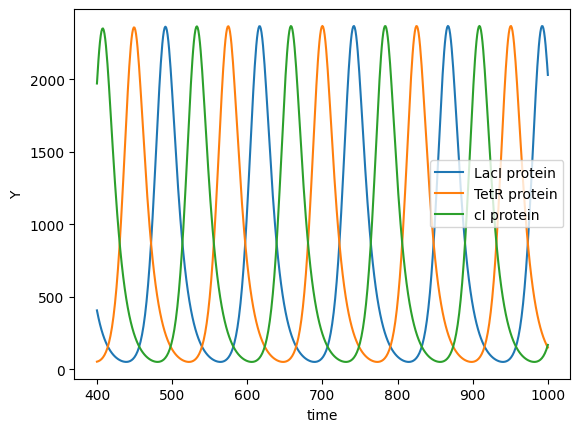

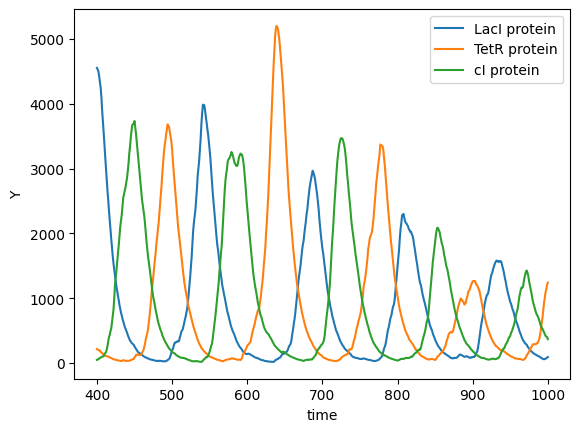

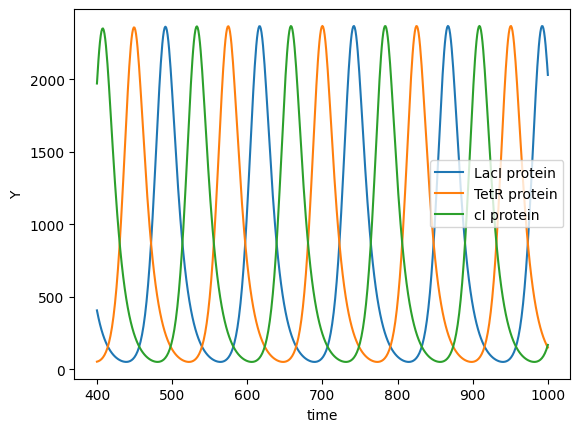

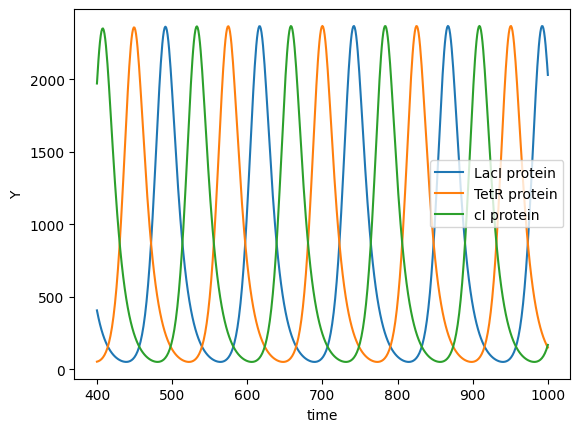

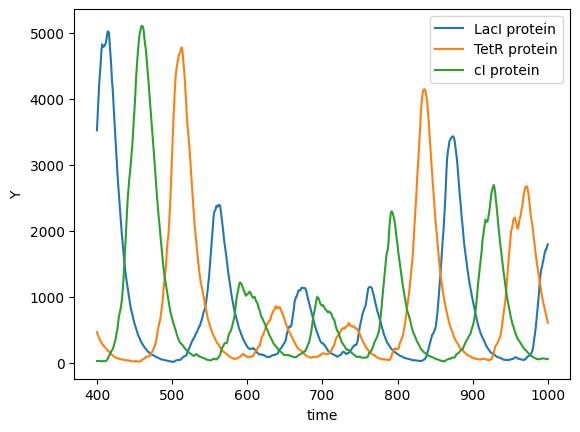

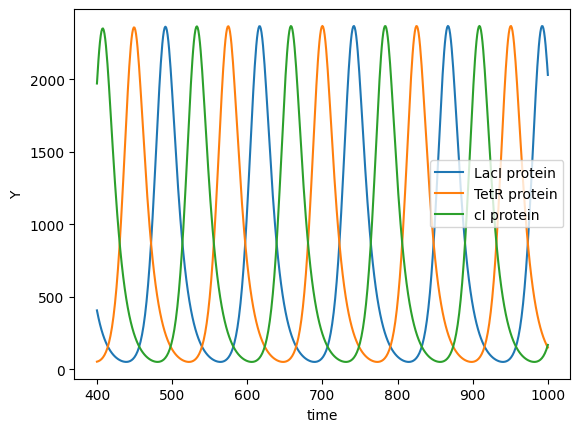

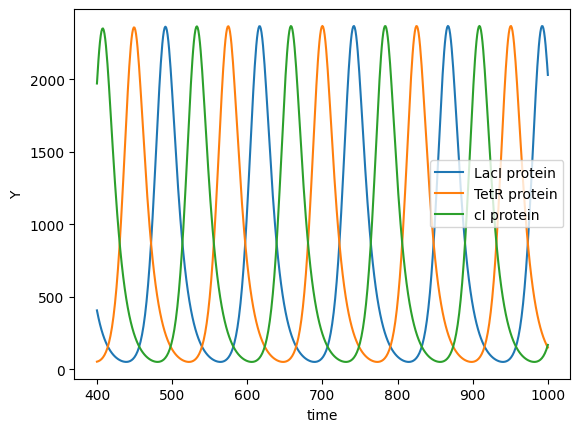

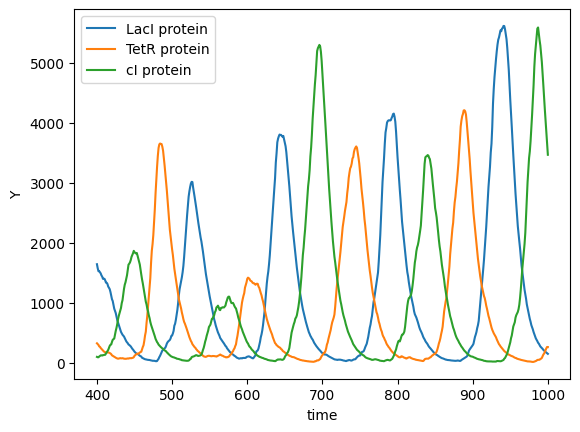

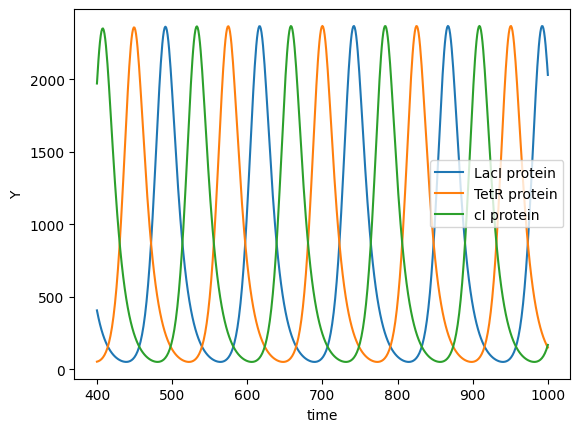

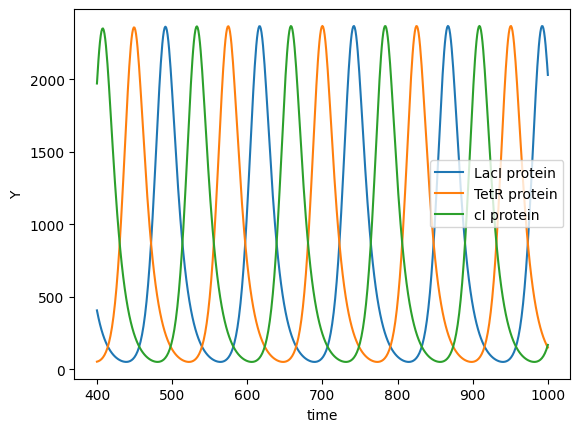

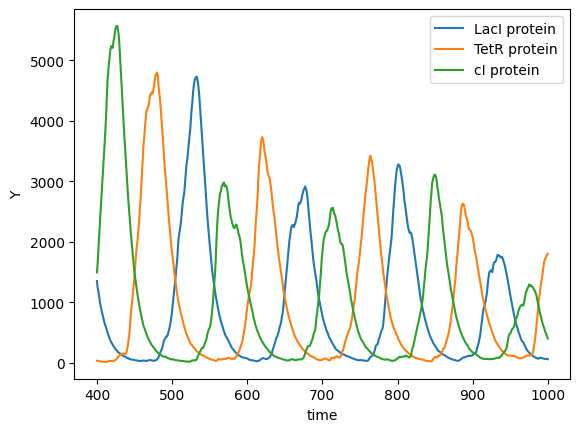

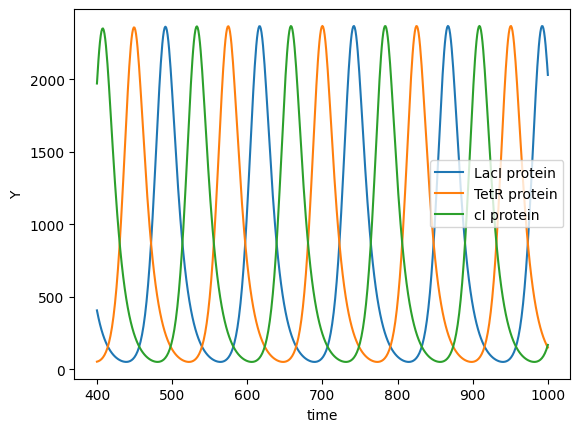

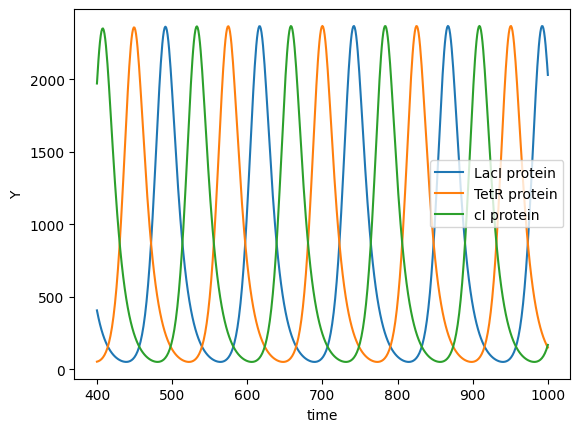

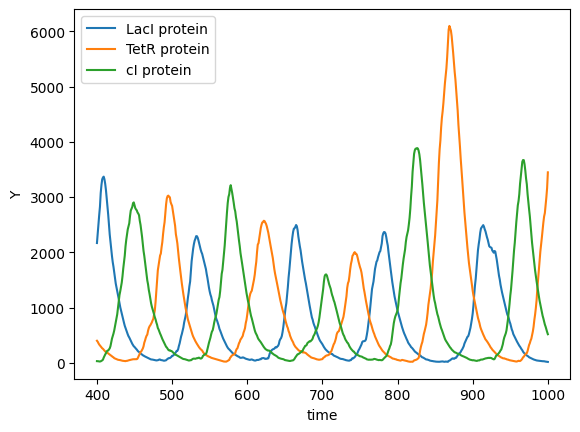

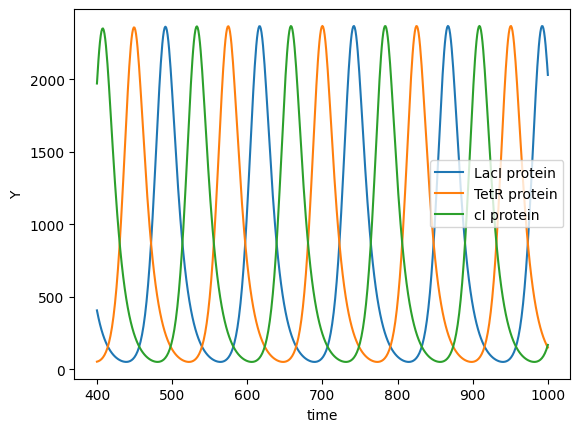

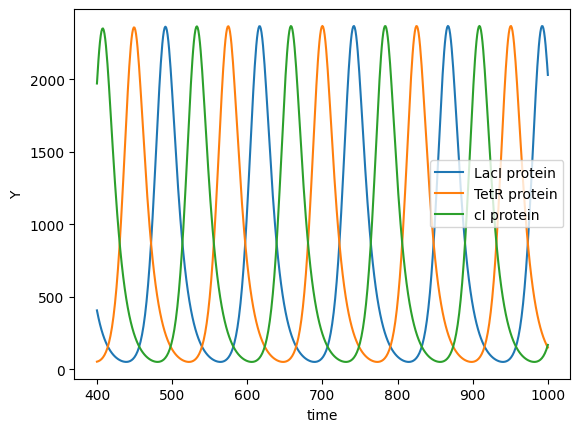

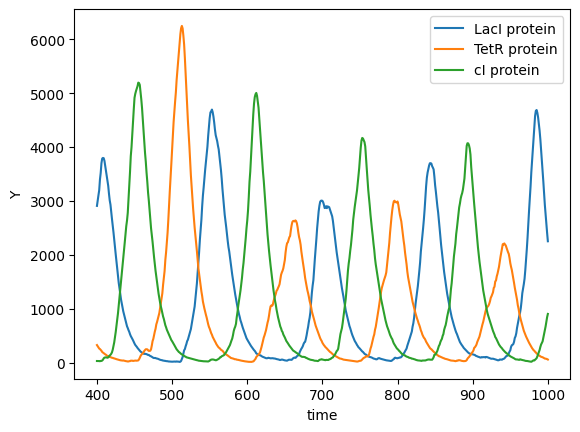

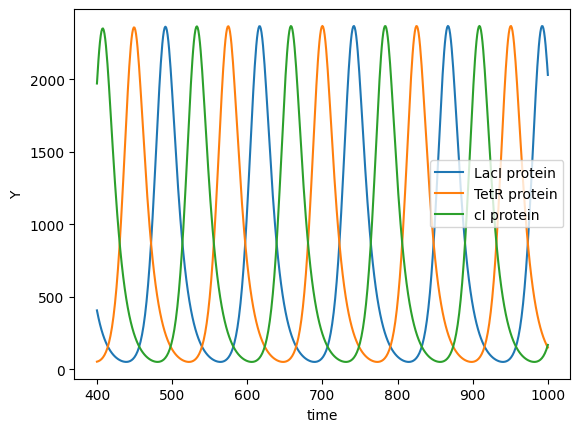

In [13]:
worker = Worker(job_params=job)

pp(f'Job result of worker: {worker.job_result}')
# request specific params

In [15]:
pp(worker.job_result)

{'results': [{'species_name': 'LacI protein',
              'mse': {'amici': {'amici': 0.0,
                                'copasi': 2481397.523699326,
                                'tellurium': 0.0005853579775907033},
                      'copasi': {'amici': 2481397.523699326,
                                 'copasi': 0.0,
                                 'tellurium': 2481397.371855482},
                      'tellurium': {'amici': 0.0005853579775907033,
                                    'copasi': 2481397.371855482,
                                    'tellurium': 0.0}},
              'proximity': {'amici': {'amici': True,
                                      'copasi': False,
                                      'tellurium': True},
                            'copasi': {'amici': False,
                                       'copasi': True,
                                       'tellurium': False},
                            'tellurium': {'amici': True,
                     

In [14]:
from shared import download_blob

source_blob = job['omex_path']
out_dir = mkdtemp()
local_omex_fp = os.path.join(out_dir, source_blob.split('/')[-1])

local_omex_fp

'/var/folders/yy/8crj8x7x5_3b86f0js6_0bn00000gr/T/tmplp68fbdt/Elowitz-Nature-2000-Repressilator.omex'

In [17]:
source_blob

'uploads/ad59a303-1ed6-4440-974f-508a176e8312/Elowitz-Nature-2000-Repressilator.omex'

In [15]:
download_blob(bucket_name=BUCKET_NAME, source_blob_name=source_blob, destination_file_name=local_omex_fp)

In [16]:
os.listdir(out_dir)

['Elowitz-Nature-2000-Repressilator.omex']

In [17]:
from google.cloud import storage

client = storage.Client()
bucket = client.bucket(BUCKET_NAME)
blob = bucket.blob(source_blob.replace('gs://bio-check-requests-1/', ''))

In [18]:
dir(blob)

['STORAGE_CLASSES',
 '_CHUNK_SIZE_MULTIPLE',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_acl',
 '_bucket',
 '_changes',
 '_chunk_size',
 '_do_download',
 '_do_multipart_upload',
 '_do_resumable_upload',
 '_do_upload',
 '_encryption_headers',
 '_encryption_key',
 '_extract_headers_from_download',
 '_get_content_type',
 '_get_download_url',
 '_get_transport',
 '_get_upload_arguments',
 '_get_writable_metadata',
 '_handle_filename_and_download',
 '_handle_filename_and_upload',
 '_initiate_resumable_upload',
 '_patch_property',
 '_prep_and_do_download',
 '_prep_and_do_upload',
 '_properties',
 '_query_params',
 '_require_client',
 '_set_properties',
 'acl',
 'bucket'

In [19]:
blob.download_to_filename(local_omex_fp) 

NotFound: 404 GET https://storage.googleapis.com/download/storage/v1/b/bio-check-requests-1/o/uploads%2Ff7796e37-5871-4d67-9ee9-1ac66b2116b3%2FElowitz-Nature-2000-Repressilator.omex?alt=media: No such object: bio-check-requests-1/uploads/f7796e37-5871-4d67-9ee9-1ac66b2116b3/Elowitz-Nature-2000-Repressilator.omex: ('Request failed with status code', 404, 'Expected one of', <HTTPStatus.OK: 200>, <HTTPStatus.PARTIAL_CONTENT: 206>)